**Goal:** To build a predictive model to predict the winning probability of teams during the final match of IPL Season 2017

Since the predictability of winning the final match in Season 2017 depends mainly on the compositions of the teams and their performances in Season 2017, we will consider only the Season 2017's data. 

In [310]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

In [311]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/ipl/"
match= pd.read_csv(data_path+"matches.csv")
score= pd.read_csv(data_path+"deliveries.csv")

In [312]:
match_df=match[(match['season']==2017) & (match['dl_applied']==0)]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Since "id" from "match_df" and match_id from score_df are common columns, we can join "season" with score_df to subset for delivary level data from Season 2017

In [313]:
score_df=score.merge(match_df[['id','season','winner']],left_on='match_id',right_on='id', how='inner')
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,id,season,winner
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad


Now we need to think about the features that are required to build the model. To get started, will list the features in 2 different sets i.e. features that are important and features that are good to add. We can change them as we keep analyzing.

1. Runs scored in a given over
2. Wickets taken in a given over
3. Cumulative score by each over
4. Cumulative wickets taken by each over
5. Target that the team is chasing down
6. Remaining target by each over
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team
11. Total runs in the last 5 overs
12. Totals wickets in the last 5 overs

In [314]:
# Runs scored and wickets taken per over #
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].ix[score_df['player_dismissed'] != 0] = 1
train_df=score_df.groupby(['match_id','inning','over','batting_team','bowling_team','winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns=[['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over']]
# Cumulative score and cumulative wickets taken by each over
train_df['innings_wickets'] = train_df.groupby(['match_id', 'innings'])['wkts_over'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'innings'])['runs_over'].cumsum()

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [315]:
# Target that the team is chasing down. if first innings, target is -1#
score_inning1=train_df.groupby(['match_id','innings','batting_team','bowling_team'])['runs_over'].sum().reset_index()
score_inning1['innings']=np.where(score_inning1['innings']==1,2,1)
train_df=train_df.merge(score_inning1,how='left',on=['match_id', 'innings'])
train_df=train_df.drop(['batting_team_y', 'bowling_team_y'],axis=1)
train_df.columns=['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over','innings_wkts','innings_runs','target']
first_innings_index = train_df[train_df.loc[:,'innings'] == 1].index
train_df.loc[first_innings_index, "target"] = -1
#train_df.head(40)

In [316]:
# Remaining target that the team is chasing down. if first innings, remaining target is -1#
train_df['remaining_target']=train_df['target']-train_df['innings_runs']
train_df.loc[first_innings_index, "remaining_target"] = -1
#train_df.head(40)

In [317]:
#Run rate
train_df['run_rate']=train_df['innings_runs']/train_df['over']
train_df.head()

,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wkts,innings_runs,target,remaining_target,run_rate
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000


In [318]:
# Required run rate. If first innings, required run rate is -1. If 20th over, equired run rate is 99 #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

In [319]:
#Difference in run rate and required run rate. If first innings, it is -1#
def get_rr_diff(row):
    if row['innings'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)

In [320]:
#Response. If batting team is winner, set 1 elseif bowling_team is winner, set 0 #
#train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['is_batting_winner'] = (train_df['batting_team'] == train_df['winner']).astype('int')
train_df.head()

,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wkts,innings_runs,target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_winner
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000,-1.0,-1.0,1
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667,-1.0,-1.0,1
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000,-1.0,-1.0,1
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000,-1.0,-1.0,1


### Function to train a Xgboost model

In [321]:
#Choose all predictors except target
predictors = ['innings', 'over', 'runs_over', 'wkts_over', 'innings_wkts', 'innings_runs', 'target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff']
response='is_batting_winner'

### Define a functions for building Xgboost model and cross-validation

Default general parameters are set to "booster = gbtree: tree-based models", "silent=0" and "nthread is set to maxumum available" 
Typical final values for parameters for reference: 
1. eta: 0.01 to 0.2 empirically <0.1 leads to better generalization, 
2. max_depth typical values between 3 to 10,
3. min_child_weight default is 1, tune using CV
4. max_leaf_nodes is 2^n for depth=n. If this is defined max_depth is ignored
5. Gamma is min loss reduction required for further splitting 
6. subsample typically is 0.5 to 1, lower values lead to lower variance.
7. colsamples_bytree typicall is o.5 to 1, reduces the correlation b/w trees.
8. lambda is L2 regularization

In [349]:
# define the function to create the model #
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[response].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[response],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[response].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[response], dtrain_predprob)
    print "n_estimator:", cvresult.shape[0] 
    return(cvresult)

    imp_df = pd.DataFrame(alg.get_booster().get_fscore().items())
    imp_df.columns=['feature','fscore']
    imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
    imp_df=imp_df.sort_values(by=['fscore'],ascending=False)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
    labels = np.array(imp_df.feature.values)
    ind = np.arange(len(labels))
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,6))
    rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
    ax.set_xticks(ind+((width)/2.))
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_ylabel("Importance score")
    ax.set_title("Variable importance")
    autolabel(rects)
    plt.show()


Model Report
Accuracy : 0.8746
AUC Score (Train): 0.957470
n_estimator: 126


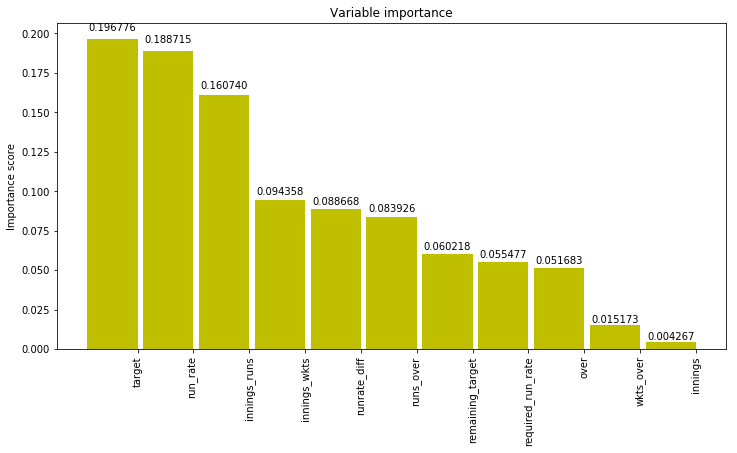

In [333]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_df, predictors)

### Grid search for max_depth and min_child_weight

In [335]:
# Set to n_estimators to to the tuned values from cross-validation
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,8,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=126, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[response])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67218, std: 0.08707, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.66912, std: 0.09209, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.66762, std: 0.09489, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.66791, std: 0.09531, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.67117, std: 0.08775, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.66942, std: 0.09296, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.67084, std: 0.09178, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.66594, std: 0.09136, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.67893, std: 0.09048, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.67151, std: 0.09088, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.67353, std: 0.09010, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.67226, std: 0.08797, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: 0.68177, std: 0.08426, params: {

Since max_depth: 9 and min_child_weight: 1 from this search, I will search max_depth in [4, 12] and min_child_weight in [1, 4] during next search.

In [327]:
# Set to n_estimators to to the tuned values from cross-validation
param_test1 = {
 'max_depth':range(4,12,2),
 'min_child_weight':range(1,4,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=126, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[response])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67320, std: 0.08799, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.66991, std: 0.09295, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.67816, std: 0.08699, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.67403, std: 0.08742, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.67865, std: 0.08754, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.67070, std: 0.09077, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.67757, std: 0.08094, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.66886, std: 0.08921, params: {'max_depth': 10, 'min_child_weight': 3}],
 {'max_depth': 8, 'min_child_weight': 1},
 0.6786485091728836)

max_depth: 9 and min_child_weight: 1 seem to be better values

### Grid Search for gamma

In [337]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=126, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_df[predictors],train_df[response])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.68177, std: 0.08426, params: {'gamma': 0.0},
  mean: 0.67556, std: 0.08458, params: {'gamma': 0.1},
  mean: 0.67738, std: 0.08492, params: {'gamma': 0.2},
  mean: 0.67916, std: 0.08506, params: {'gamma': 0.3},
  mean: 0.67728, std: 0.08313, params: {'gamma': 0.4},
  mean: 0.67864, std: 0.08519, params: {'gamma': 0.5},
  mean: 0.67574, std: 0.08221, params: {'gamma': 0.6},
  mean: 0.67837, std: 0.08398, params: {'gamma': 0.7},
  mean: 0.67583, std: 0.08527, params: {'gamma': 0.8},
  mean: 0.67662, std: 0.08473, params: {'gamma': 0.9}],
 {'gamma': 0.0},
 0.6817666263449181)

Gamma: 0 is the optimal value. Let us recalibrate the n_estimator based on the tuned parameters.


Model Report
Accuracy : 0.8887
AUC Score (Train): 0.965317
n_estimator: 49


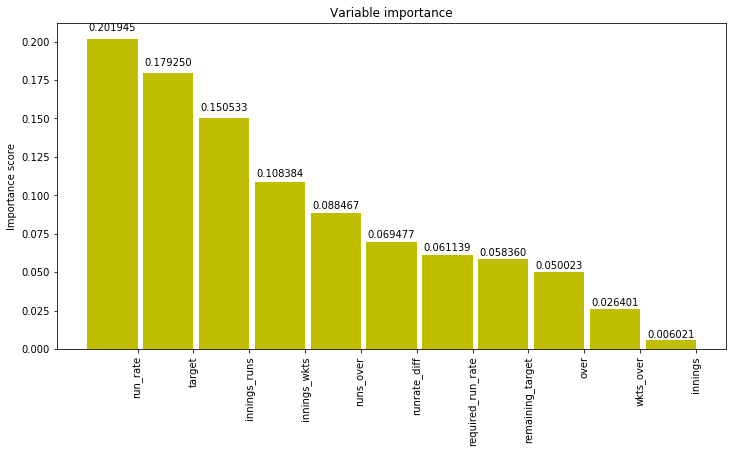

In [338]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=126,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_df, predictors)

This changed the variable importance. Observe!!

### Grid Search subsample and colsample_bytree

In [340]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=49, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_df[predictors],train_df[response])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.67579, std: 0.09629, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.67242, std: 0.09784, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.67488, std: 0.09415, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.67123, std: 0.09308, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.67333, std: 0.09225, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.67748, std: 0.09437, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.67698, std: 0.08882, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.67484, std: 0.09377, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.67329, std: 0.09513, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.67487, std: 0.09263, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.67927, std: 0.08936, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.67624, std: 0.08897, params: {'subsample': 0.9, 'colsample_bytree'

Since colsample_bytree=: 0.9, subsample: 0.8, let us search by 0.05 around these values.

In [342]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,95,5)],
 'colsample_bytree':[i/100.0 for i in range(70,95,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=49, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_df[predictors],train_df[response])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.67501, std: 0.08950, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: 0.67698, std: 0.08882, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.67937, std: 0.09167, params: {'subsample': 0.85, 'colsample_bytree': 0.7},
  mean: 0.67484, std: 0.09377, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.68061, std: 0.08801, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: 0.67927, std: 0.08936, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: 0.67703, std: 0.08594, params: {'subsample': 0.85, 'colsample_bytree': 0.75},
  mean: 0.67624, std: 0.08897, params: {'subsample': 0.9, 'colsample_bytree': 0.75},
  mean: 0.68061, std: 0.08801, params: {'subsample': 0.75, 'colsample_bytree': 0.8},
  mean: 0.67927, std: 0.08936, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.67703, std: 0.08594, params: {'subsample': 0.85, 'colsample_bytree': 0.8},
  mean: 0.67624, std: 0.08897, params: {'subsample': 0.9, 'colsamp

Since colsample_bytree=: 0.85, subsample: 0.85 improved the auc, let us set them to those values.

### Grid Search on regularization parameters

Since the dimensionality of the predictors is low, we don't need L1 regularization but L2 regularization would control overfitting as the depth of trees is high.

In [343]:
param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=49, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.85, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_df[predictors],train_df[response])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.68378, std: 0.07936, params: {'reg_lambda': 1e-05},
  mean: 0.68612, std: 0.07956, params: {'reg_lambda': 0.01},
  mean: 0.68391, std: 0.07996, params: {'reg_lambda': 0.1},
  mean: 0.68246, std: 0.08416, params: {'reg_lambda': 1},
  mean: 0.67229, std: 0.09688, params: {'reg_lambda': 100}],
 {'reg_lambda': 0.01},
 0.6861200268957923)


Model Report
Accuracy : 0.9143
AUC Score (Train): 0.979794
n_estimator: 49


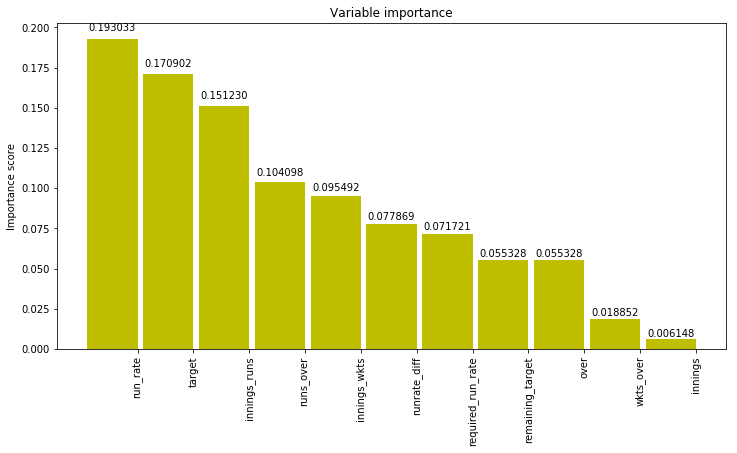

In [345]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=49,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train_df, predictors)

#### Reduce learning rate and add more trees


Model Report
Accuracy : 0.9298
AUC Score (Train): 0.986488
n_estimator: 123


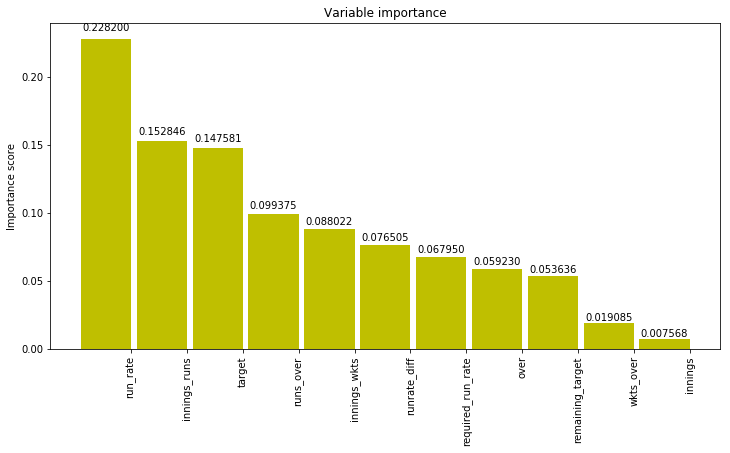

In [346]:
xgb4 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=500,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train_df, predictors)

In [350]:
xgb5 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=123,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train_df, predictors)


Model Report
Accuracy : 0.9298
AUC Score (Train): 0.986488
n_estimator: 123


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.750496,0.021125,0.819627,0.023327
1,0.786612,0.012545,0.867464,0.011768
2,0.796987,0.020264,0.887126,0.007981
3,0.806436,0.017743,0.895375,0.008935
4,0.808239,0.015177,0.899944,0.008628
5,0.806969,0.015769,0.907313,0.004675
6,0.809661,0.018011,0.912349,0.007593
7,0.814031,0.015555,0.917179,0.005527
8,0.818100,0.014896,0.920215,0.005937
9,0.820020,0.017346,0.922440,0.006378
